# Taller 3

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.cog import write_cog
from datacube.utils.rio import configure_s3_access
from utils import display_map, coordinate_converter, extract_data

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [2]:
dc = datacube.Datacube(app='sampleo') 

## Carga de puntos de muestreo

In [3]:
ma = gpd.read_file("../taller_02/vectores/muestreo_aleatorio.shp")

In [4]:
cuencas = gpd.read_file("../taller_02/vectores/Cuencas_BNA.shp")
cuenca = cuencas.loc[cuencas.COD_CUEN == "070"]
x0, y0, x1, y1 = cuenca.to_crs(4326).bounds.values[0]

Área original de trabajo:

In [5]:
display_map((y0, y1), (x0, x1))

## Eligiendo una sub-región

Debido al tamaño de la zona, es mejor trabajar con un sector más pequeño, de no más de 10km x 10km (300 x 300 píxeles). Los límites originales son los siguientes:

In [6]:
print(cuenca.crs)
print(cuenca.bounds.values[0])

EPSG:32719
[ 208863.8446 6125493.2888  250822.0704 6154898.2974]


Por lo que debemos elegir coordenadas dentro de este rango. Por ejemplo:

In [7]:
radio = 10000
x0 = 225000; x1 = x0 + radio
y0 = 6140000; y1 = y0 + radio
xx, yy = coordinate_converter([x0, x1], [y0, y1], cuenca.crs)
y0, y1 = xx
x0, x1 = yy

display_map((y0, y1), (x0, x1))

## Carga de imágenes

### Landcover Zhao 2014

In [8]:
query = {
    "product": ["landcover_chile_2014"],
    "y": (y0, y1), 
    "x": (x0, x1),
    "time": ("2014-01-01", "2023-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    # "group_by": "solar_day"
}

lc = dc.load(**query).squeeze()
lc

<xarray.Dataset>
Dimensions:      (y: 334, x: 353)
Coordinates:
    time         datetime64[ns] 2014-12-31
  * y            (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x            (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref  int32 32719
Data variables:
    nivel_1      (y, x) uint16 dask.array<chunksize=(334, 353), meta=np.ndarray>
    nivel_2      (y, x) uint16 dask.array<chunksize=(334, 353), meta=np.ndarray>
    nivel_3      (y, x) uint16 dask.array<chunksize=(334, 353), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

### Serie Landsat-8

In [9]:
query["product"] = "landsat8_c2l2_sr"
ds_ = dc.load(**query)
ds_

<xarray.Dataset>
Dimensions:      (time: 398, y: 334, x: 353)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2023-11...
  * y            (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x            (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint8 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

Sólo necesito la sfechas que especifiqué en el taller 2. Por ejemplo:

In [10]:
mis_fechas = ["2017-02-09", "2017-04-30"]  # antes, después

Y hago un subset por esas fechas solamente, y luego sigo con el procesamiento. Revisar que la cobertura de nubes sea la menor posible en ambas escenas

In [11]:
ds = ds_.sel(time = ds_.time.isin( ds_.time[ds_.time.dt.strftime("%Y-%m-%d").isin(mis_fechas)] ))
ds

<xarray.Dataset>
Dimensions:      (time: 2, y: 334, x: 353)
Coordinates:
  * time         (time) datetime64[ns] 2017-02-09T14:40:12.899143 2017-04-30T...
  * y            (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x            (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint8 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [12]:
quality_band = 'qa_pixel'
refl_bands = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22"]
cloud_free_mask = (
    masking.make_mask(ds[quality_band], snow='high_confidence') + 
    masking.make_mask(ds[quality_band], cloud="high_confidence") +
    masking.make_mask(ds[quality_band], cirrus="high_confidence") +
    masking.make_mask(ds[quality_band], cloud_shadow="high_confidence") +
    masking.make_mask(ds[quality_band], nodata=True)
)
dsf = xr.where(cloud_free_mask, np.nan, ds[refl_bands])
dsf.update(dsf * 0.0000275 + -0.2)
dsf.update(dsf.where(dsf >= 0).where(dsf <= 1))

<xarray.Dataset>
Dimensions:      (time: 2, y: 334, x: 353)
Coordinates:
  * time         (time) datetime64[ns] 2017-02-09T14:40:12.899143 2017-04-30T...
  * y            (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x            (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 334, 353), meta=np.ndarray>

In [13]:
ndvi = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])
ndvi = xr.where((ndvi > 1) | (ndvi < -1), np.nan, ndvi)
ndvi.attrs = ds.attrs

evi = 2.5 * ((dsf['nir08'] - dsf['red']) / (dsf['nir08'] + 6 * dsf['red'] - 7.5 * dsf['blue'] + 1))
evi = xr.where((evi > 1) | (evi < -1), np.nan, evi)
evi.attrs = ds.attrs

ndvi

<xarray.DataArray (time: 2, y: 334, x: 353)>
dask.array<where, shape=(2, 334, 353), dtype=float64, chunksize=(1, 334, 353), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2017-02-09T14:40:12.899143 2017-04-30T...
  * y            (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x            (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref  int32 32719
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

### Se genera un archivo de diferencias

Calculamos la diferencia entre antes vs después. Esto para facilitar análisis con posterioridad

In [14]:
dsf2 = xr.merge([dsf, ndvi.rename("ndvi").to_dataset(), evi.rename("evi").to_dataset()])
difd = dsf2.isel(time=1) - dsf2.isel(time=0)

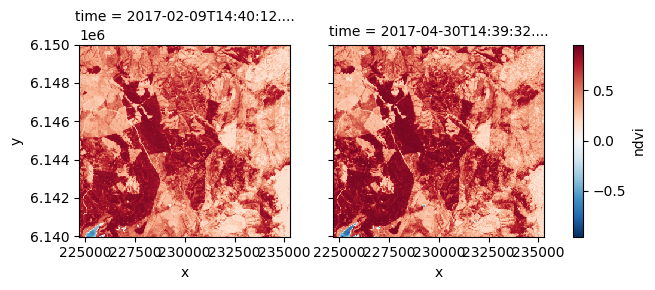

In [15]:
dsf2.ndvi.plot(col="time")

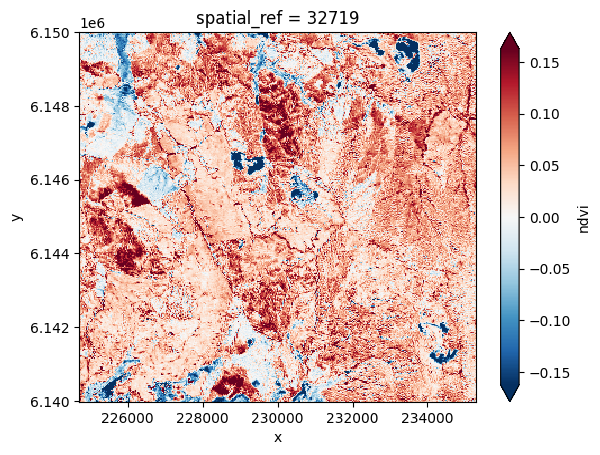

In [16]:
difd.ndvi.plot(robust=True)

## Cálculo de texturas

In [17]:
from textures import glcm_texture
import dask.array as da
import math
import datetime

variable = "ndvi"
levels = 2**4
radius = 1
distances = [1]
angles = [0, math.pi / 4]

abs_ = abs(difd[variable] + 1)  # no pueden entrar valores negativos, y +1 para no perder los valores negativos
dif_text = np.ceil((abs_/abs_.max() * (levels - 1))).astype(
    "ubyte"
) 

darr = da.from_array(dif_text, chunks=(50, 50))
chunks_ = tuple([(5,)] + list(darr.chunks))

mb_kwargs = {
    "dtype": float,  # Review
    "chunks": chunks_,  # Done
    "drop_axis": None,  # Done
    "new_axis": 0,  # Done
    "radius": radius,  # Done, func kwarg
    "distances": distances,  # Done
    "angles": angles,  # Done
    "levels": levels,  # Done
}

/env/lib/python3.10/site-packages/dask/array/core.py:3470: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


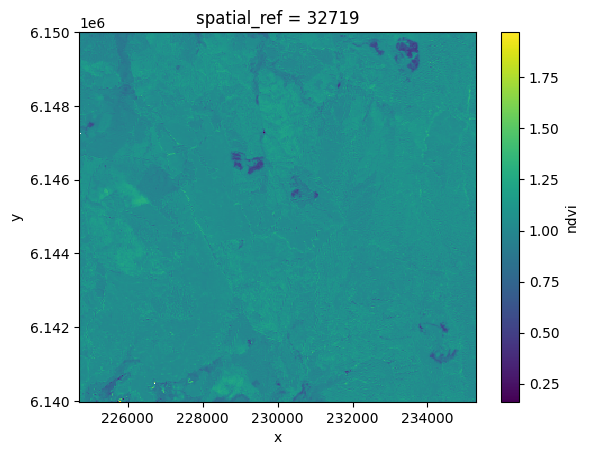

In [18]:
abs_.plot()

/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 7.7000e+01,
        3.2700e+02, 5.3000e+02, 2.8390e+03, 6.6134e+04, 4.6813e+04,
        1.1440e+03, 2.8000e+01, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15.]),
 <BarContainer object of 15 artists>)

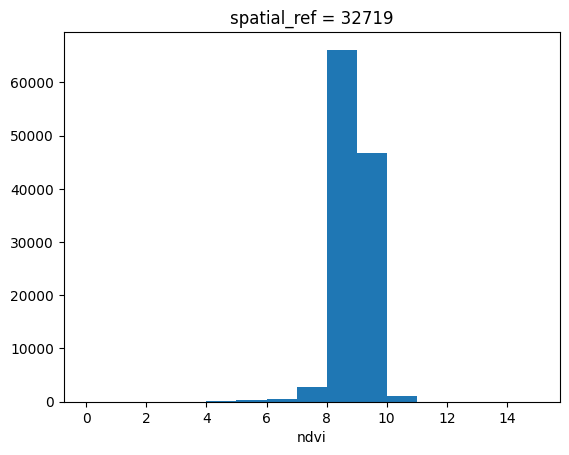

In [19]:
dif_text.plot.hist(bins=range(levels))

In [20]:
gcp = da.map_overlap(
    glcm_texture,
    darr,
    depth=radius,
    boundary=0,
    trim=False,
    align_arrays=False,
    allow_rechunk=False,
    normed=True,
    symmetric=True,
    **mb_kwargs,
)
gcp

/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


dask.array<glcm_texture, shape=(5, 334, 353), dtype=float64, chunksize=(5, 50, 50), chunktype=numpy.ndarray>

> Observe como funciona el cluster en el link: https://hub.datacubechile.cl/user/MI_USUARIO/proxy/8787/status (reemplace MI_USUARIO por su nombre de usuario)

En el siguiente chunk saldrán varios mensajes de advertencia; ignorarlos (los mensajes de error, ¡NO!).

In [21]:
tini = datetime.datetime.now()
gcp_mem = gcp.compute()
tfin = datetime.datetime.now()
print(tfin - tini)

/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/env/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encou

0:02:34.342935


In [22]:
texs = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
ab = xr.DataArray(gcp_mem, 
                  dims=["texture", "y", "x"],
                  coords=[texs, abs_.coords["y"], abs_.coords["x"]])
texturas = ab.to_dataset("texture")

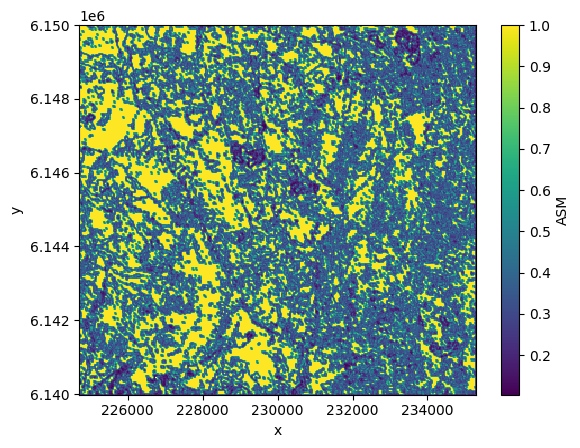

In [23]:
texturas.ASM.plot()

## Topografía

In [24]:
import xrspatial as xrs

query["product"] = "copernicus_dem_30"
dem = dc.load(**query).squeeze(drop=True)

slope = xrs.slope(dem.elevation).to_dataset()  # en grados
aspect = xrs.aspect(dem.elevation)

# Circular/Cyclical Encoding
radians = np.radians(aspect)
aspect_sin = np.sin(radians).rename("aspect_sin").to_dataset()
aspect_cos = np.cos(radians).rename("aspect_cos").to_dataset()

topo = xr.merge([dem, slope, aspect_sin, aspect_cos])

In [25]:
todo = xr.merge([lc, difd, texturas, topo]).compute()

In [26]:
todo

<xarray.Dataset>
Dimensions:        (y: 334, x: 353)
Coordinates:
    time           datetime64[ns] 2014-12-31
  * y              (y) float64 6.15e+06 6.15e+06 6.15e+06 ... 6.14e+06 6.14e+06
  * x              (x) float64 2.247e+05 2.247e+05 ... 2.352e+05 2.353e+05
    spatial_ref    int32 32719
Data variables: (12/22)
    nivel_1        (y, x) uint16 400 400 400 400 400 400 ... 300 300 300 300 300
    nivel_2        (y, x) uint16 410 410 410 410 410 410 ... 250 250 250 250 250
    nivel_3        (y, x) uint16 410 410 410 410 410 410 ... 251 251 251 251 251
    coastal        (y, x) float64 0.004702 0.006462 ... 0.003548 -0.001595
    blue           (y, x) float64 0.002887 0.005198 ... 0.002117 -0.001595
    green          (y, x) float64 -0.001677 0.000165 ... 0.00495 -0.003768
    ...             ...
    correlation    (y, x) float64 nan nan nan nan ... 0.3001 0.3551 -0.08162
    ASM            (y, x) float64 nan nan nan nan ... 0.2101 0.2483 0.2604
    elevation      (y, x) float32 52.35 51.43 47.71 42.89 ... 143.5 146.5 149.2
    slope          (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    aspect_sin     (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    aspect_cos     (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [27]:
mdata = extract_data(todo, ma, include_xy=True).dropna()
mdata

,x,y,nivel_1,nivel_2,nivel_3,coastal,blue,green,red,nir08,...,contrast,dissimilarity,homogeneity,energy,correlation,ASM,elevation,slope,aspect_sin,aspect_cos
id,,,,,,,,,,,,,,,,,,,,,
4,231120.262913,6.144118e+06,300.0,250.0,251.0,-0.007617,-0.010340,-0.018425,-0.031130,-0.031927,...,1.625000,1.208333,0.437500,0.579971,-0.818480,0.336806,254.944489,9.370442,0.757486,-0.652851
9,229841.883902,6.141800e+06,400.0,410.0,410.0,-0.006187,-0.011412,-0.015565,-0.019305,-0.039270,...,0.375000,0.375000,0.812500,0.550002,0.219048,0.303819,58.597946,9.343623,-0.995705,-0.092583
27,234400.510388,6.142632e+06,300.0,250.0,251.0,-0.005307,-0.007782,-0.013338,-0.017215,-0.027610,...,0.458333,0.458333,0.770833,0.556674,0.066667,0.310764,194.764160,16.729700,-0.364685,-0.931131
118,233657.893957,6.141297e+06,400.0,410.0,410.0,-0.002310,-0.006518,-0.005527,-0.007975,0.000440,...,0.708333,0.708333,0.645833,0.581826,-0.550000,0.338542,288.918091,10.236385,-0.838145,-0.545448
121,228953.797368,6.142837e+06,400.0,410.0,410.0,-0.010780,-0.016143,-0.029672,-0.030635,-0.072848,...,0.291667,0.291667,0.854167,0.738829,-0.171429,0.546875,44.562843,5.658046,-0.587081,-0.809528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9926,228950.504523,6.141526e+06,400.0,410.0,410.0,-0.004702,-0.007975,-0.014135,-0.013255,-0.017545,...,0.416667,0.416667,0.791667,0.659740,-0.266667,0.437500,24.395412,4.118849,0.909538,-0.415620
9936,228998.772237,6.140148e+06,400.0,410.0,410.0,-0.001458,-0.002942,-0.015840,-0.012953,-0.128205,...,0.541667,0.541667,0.729167,0.581826,-0.175000,0.338542,3.923696,0.485989,-0.416710,-0.909039
9953,227302.991050,6.141330e+06,200.0,240.0,241.0,0.001595,-0.003878,-0.001512,0.003245,-0.022028,...,0.458333,0.458333,0.770833,0.599337,0.028571,0.359375,89.482460,17.455328,-0.569355,0.822092


In [28]:
mdata.to_csv("minfo.csv")

In [29]:
if False:
    client.close()
    cluster.close()